In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns
import statsmodels.api as sm
import datetime
import shap
import geopandas as gpd
from shapely.geometry import Point
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
import xgboost, shap
from sklearn.inspection import PartialDependenceDisplay

In [2]:
# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
# **Step 1: get the data**

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
unit_df = pd.read_csv('/content/drive/My Drive/X999/new_df_unit.csv')

In [7]:
nta_df = pd.read_csv('/content/drive/My Drive/X999/new_df_nta.csv')

In [8]:
bin_df = pd.read_csv('/content/drive/My Drive/X999/new_df_bin.csv')

In [9]:
zipcodes_df = pd.read_csv('/content/drive/My Drive/X999/new_df_zipcode.csv')

In [10]:
racial_vars = ['ep_afam', 'ep_hisp', 'ep_asian', 'ep_nhpi', 'ep_twomore', 'ep_otherrace', 'ep_minrty', 'ep_white']
gentrification_vars= ['avg_idr','avg_idr_change','income_change','income_change_ratio']
socialeconomic_vars = ['ep_pov150', 'ep_unemp', 'ep_nohsdp', "median_income",
 'ep_uninsur', 'ep_age65', 'ep_age17', 'ep_disabl', 'ep_limeng', 'ep_noveh', 'ep_crowd', 'ep_hburd',]
svi_vars = ["rpl_theme1", "rpl_theme2", "rpl_theme3", "rpl_theme4", 'rpl_themes']
building_vars = ['numfloors', 'unitsres', 'bldgarea', 'bldgclass','building_type', 'architectural_style', "building_age",
                    'building_category', 'is_condo','is_llc']
complaints_vars = ['air_quality', 'animal_issues', 'appliances',  'building_exterior', 'doors_windows', 'electrical_issues', 'elevator_issues',
'floors_stairs','general_complaints', 'graffiti_posting', 'heat_hot_water','homeless_issues', 'noise_complaints','other_issues', 'pest_issues',
'plumbing_issues', 'police_matters', 'public_nuisance','safety_concerns', 'sanitation_issues', 'walls_ceilings', 'total_complaints']
feature_columns = racial_vars + socialeconomic_vars + svi_vars + building_vars + complaints_vars + gentrification_vars

In [11]:
unit_df['comp_systems_utilities'] = unit_df['heat_hot_water'] + unit_df['plumbing_issues'] + unit_df['electrical_issues'] + unit_df['elevator_issues']
unit_df['comp_structure_maintenance'] = unit_df['doors_windows'] + unit_df['walls_ceilings'] + unit_df['floors_stairs'] + unit_df['building_exterior'] + unit_df['appliances']
unit_df['comp_health_env'] = unit_df['sanitation_issues'] + unit_df['pest_issues'] + unit_df['air_quality']
unit_df['comp_noise'] = unit_df['noise_complaints']
unit_df['comp_public_space'] = unit_df['homeless_issues'] + unit_df['graffiti_posting'] + unit_df['public_nuisance']
unit_df['comp_living_safety'] = unit_df['safety_concerns'] + unit_df['animal_issues'] + unit_df['police_matters']
unit_df['comp_misc'] = unit_df['general_complaints'] + unit_df['other_issues']

In [12]:
bin_df['comp_systems_utilities'] = bin_df['heat_hot_water'] + bin_df['plumbing_issues'] + bin_df['electrical_issues'] + bin_df['elevator_issues']
bin_df['comp_structure_maintenance'] = bin_df['doors_windows'] + bin_df['walls_ceilings'] + bin_df['floors_stairs'] + bin_df['building_exterior'] + bin_df['appliances']
bin_df['comp_health_env'] = bin_df['sanitation_issues'] + bin_df['pest_issues'] + bin_df['air_quality']
bin_df['comp_noise'] = bin_df['noise_complaints']
bin_df['comp_public_space'] = bin_df['homeless_issues'] + bin_df['graffiti_posting'] + bin_df['public_nuisance']
bin_df['comp_living_safety'] = bin_df['safety_concerns'] + bin_df['animal_issues'] + bin_df['police_matters']
bin_df['comp_misc'] = bin_df['general_complaints'] + bin_df['other_issues']

In [16]:
zipcodes_df['comp_systems_utilities'] = zipcodes_df['heat_hot_water'] + zipcodes_df['plumbing_issues'] + zipcodes_df['electrical_issues'] + zipcodes_df['elevator_issues']
zipcodes_df['comp_structure_maintenance'] = zipcodes_df['doors_windows'] + zipcodes_df['walls_ceilings'] + zipcodes_df['floors_stairs'] + zipcodes_df['building_exterior'] + zipcodes_df['appliances']
zipcodes_df['comp_health_env'] = zipcodes_df['sanitation_issues'] + zipcodes_df['pest_issues'] + zipcodes_df['air_quality']
zipcodes_df['comp_noise'] = zipcodes_df['noise_complaints']
zipcodes_df['comp_public_space'] = zipcodes_df['homeless_issues'] + zipcodes_df['graffiti_posting'] + zipcodes_df['public_nuisance']
zipcodes_df['comp_living_safety'] = zipcodes_df['safety_concerns'] + zipcodes_df['animal_issues'] + zipcodes_df['police_matters']
zipcodes_df['comp_misc'] = zipcodes_df['general_complaints'] + zipcodes_df['other_issues']

In [17]:
nta_df['comp_systems_utilities'] = nta_df['heat_hot_water'] + nta_df['plumbing_issues'] + nta_df['electrical_issues'] + nta_df['elevator_issues']
nta_df['comp_structure_maintenance'] = nta_df['doors_windows'] + nta_df['walls_ceilings'] + nta_df['floors_stairs'] + nta_df['building_exterior'] + nta_df['appliances']
nta_df['comp_health_env'] = nta_df['sanitation_issues'] + nta_df['pest_issues'] + nta_df['air_quality']
nta_df['comp_noise'] = nta_df['noise_complaints']
nta_df['comp_public_space'] = nta_df['homeless_issues'] + nta_df['graffiti_posting'] + nta_df['public_nuisance']
nta_df['comp_living_safety'] = nta_df['safety_concerns'] + nta_df['animal_issues'] + nta_df['police_matters']
nta_df['comp_misc'] = nta_df['general_complaints'] + nta_df['other_issues']

In [18]:
unit_df.head(1)

,Location,primary_key,bbl,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,zipcode,latitude,longitude,community_board,council_district,census_tract,bin,nta,year,month_year,eviction_count_nta,eviction_count_building,eviction_count_unit,eviction_count_zipcode,numfloors,unitsres,bldgarea,building_type,building_age,is_condo,is_llc,air_quality,animal_issues,appliances,building_exterior,doors_windows,electrical_issues,elevator_issues,floors_stairs,general_complaints,graffiti_posting,heat_hot_water,homeless_issues,noise_complaints,other_issues,pest_issues,plumbing_issues,police_matters,public_nuisance,safety_concerns,sanitation_issues,walls_ceilings,total_complaints,avg_idr,avg_idr_change,income_change,income_change_ratio,median_income,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,ep_uninsur,ep_age65,ep_age17,ep_disabl,ep_limeng,ep_noveh,ep_crowd,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white,bldgclass,building_category,architectural_style,comp_systems_utilities,comp_structure_maintenance,comp_health_env,comp_noise,comp_public_space,comp_living_safety,comp_misc
0,Lower East Side,014679/18_115084,1002600001,014679/18,115084,630 WATER STREET,05E,2019-03-15,MANHATTAN,10002,40.711381,-73.982866,3.0,2.0,202.0,1077523,Lower East Side,2019,2019-03,56.727497,0.6,0.000738,61.0,6.0,813.0,513000.0,0,84.0,0,0,6.0,2.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,942.0,4.0,10.0,10.0,9.0,4.0,0.0,1.0,0.0,998.0,10.594985,7.277571,5956.73487,12.275533,51503.632565,0.9639,0.8781,0.9369,0.9254,0.9656,36.8,7.6,30.0,5.4,23.1,13.1,13.0,24.7,82.8,6.8,40.8,8.0,26.0,37.2,0.0,2.4,0.8,74.4,25.6,27,74,71,14.0,3.0,17.0,942.0,7.0,11.0,4.0


# **Unit Level**

In [23]:
racial_vars = ['ep_afam', 'ep_hisp', 'ep_asian', 'ep_nhpi', 'ep_twomore', 'ep_otherrace', 'ep_minrty', 'ep_white']
gentrification_vars= ['avg_idr','avg_idr_change','income_change','income_change_ratio']
socialeconomic_vars = ['ep_pov150', 'ep_unemp', 'ep_nohsdp', "median_income",
 'ep_uninsur', 'ep_age65', 'ep_age17', 'ep_disabl', 'ep_limeng', 'ep_noveh', 'ep_crowd', 'ep_hburd',]
svi_vars = ["rpl_theme1", "rpl_theme2", "rpl_theme3", "rpl_theme4", 'rpl_themes']
building_vars = ['numfloors', 'unitsres', 'bldgarea', 'bldgclass','building_type', 'architectural_style', "building_age",
                    'building_category', 'is_condo','is_llc']
complaints_vars = ['comp_systems_utilities', 'comp_structure_maintenance', 'comp_health_env', 'comp_noise', 'comp_public_space', 'comp_living_safety', 'comp_misc']
feature_columns = racial_vars + socialeconomic_vars + svi_vars + building_vars + complaints_vars + gentrification_vars

In [24]:
len(feature_columns)

46

In [25]:
X = unit_df[feature_columns]
y = unit_df['eviction_count_unit']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# stop

In [28]:
model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_svi.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [29]:
model_rfr_svi.score(X_test, y_test)

0.9118137509863328

PermutationExplainer explainer: 501it [04:16,  1.90it/s]


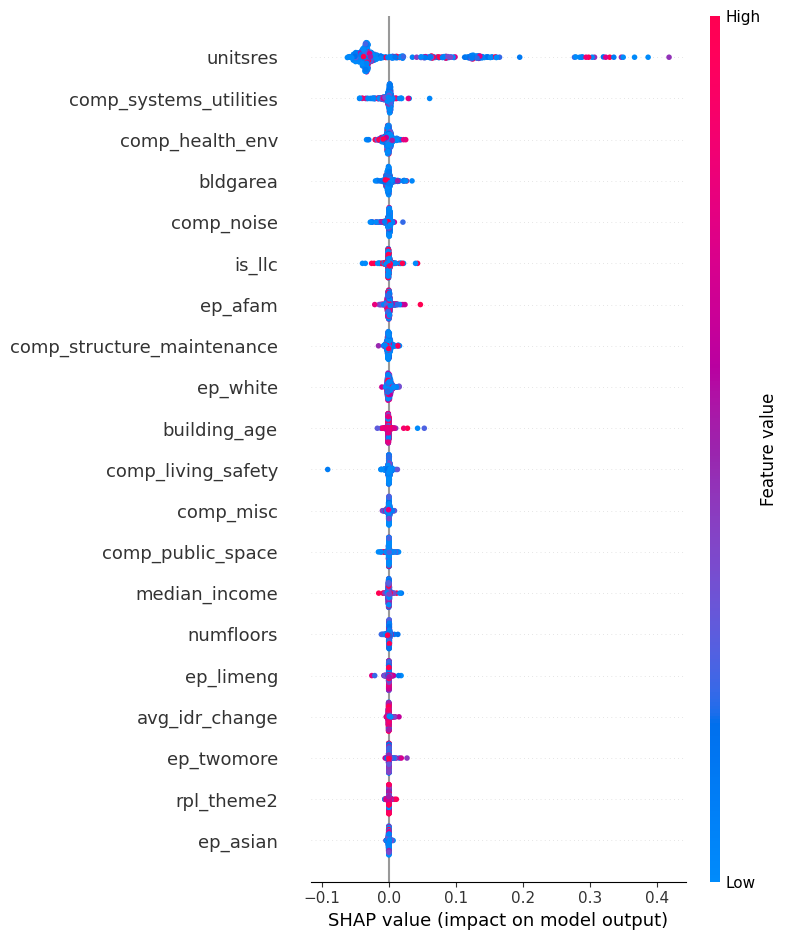

In [30]:
# model.predict instead of model, faster
explainer = shap.Explainer(model_rfr_svi.predict, X)
# need to only select the first few hundreds of samples to run
shap_values = explainer.shap_values(X.sample(n=500))
shap.summary_plot(shap_values, X.sample(n=500))

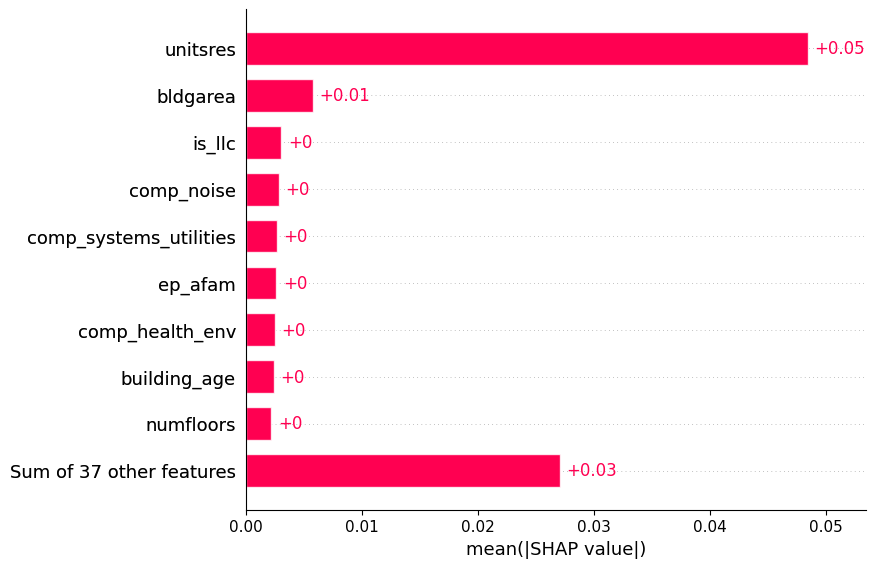

In [31]:
model = xgboost.XGBRegressor()
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.plots.bar(shap_values)

In [32]:
top_features_idx = np.argsort(model_rfr_svi.feature_importances_)[-10:]
top_features = [feature_columns[i] for i in top_features_idx]

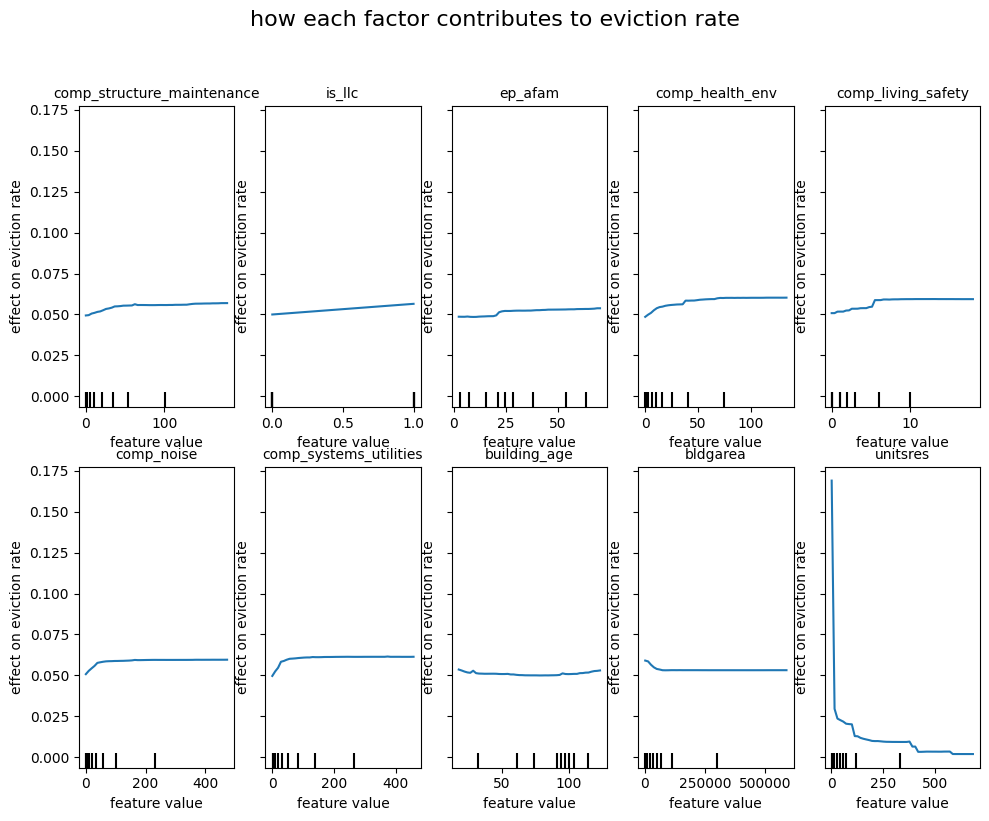

In [33]:
display = PartialDependenceDisplay.from_estimator(
    model_rfr_svi,
    X,
    features=top_features,
    kind='average',
    grid_resolution=50,
    n_cols=5,
)

plt.gcf().set_size_inches(10, 8)
plt.suptitle('how each factor contributes to eviction rate', fontsize=16, y=1.02)
for ax, feature_name in zip(display.axes_.ravel(), top_features):
    ax.set_title(feature_name, fontsize=10)
    ax.set_xlabel('feature value')
    ax.set_ylabel('effect on eviction rate')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
# see below

## **Building Level (full)**

In [34]:
X= bin_df[feature_columns]
y= bin_df['eviction_count_building']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_svi.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [37]:
model_rfr_svi.score(X_test, y_test)

0.9967660184081949

PermutationExplainer explainer: 501it [03:30,  2.26it/s]


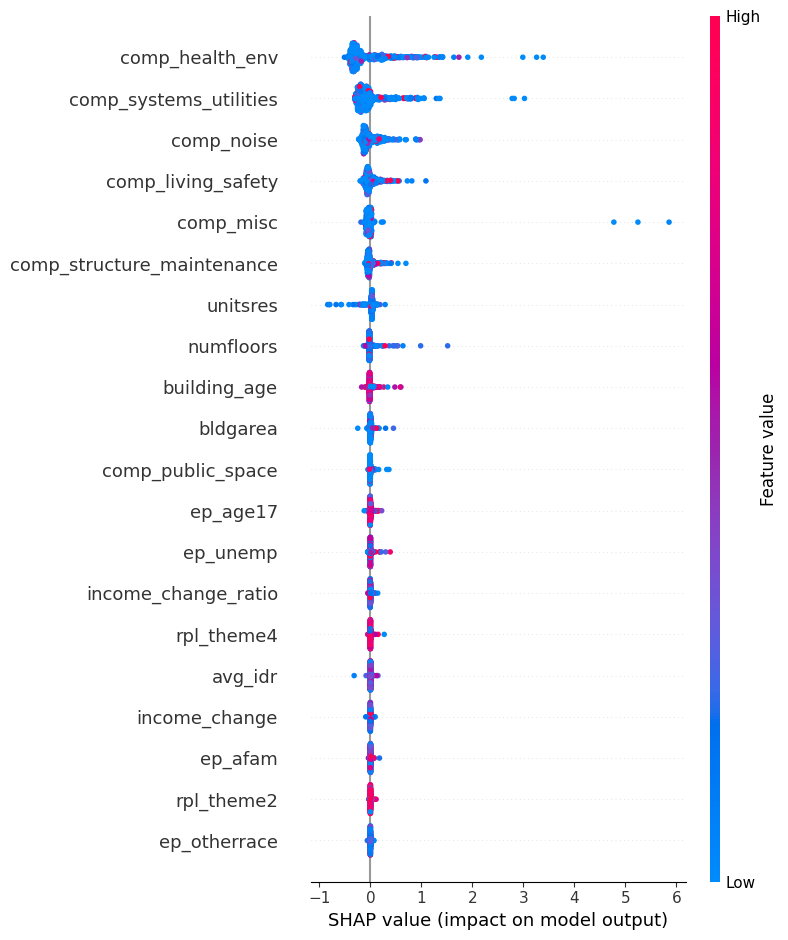

In [38]:
# model.predict instead of model, faster
explainer = shap.Explainer(model_rfr_svi.predict, X)
# need to only select the first few hundreds of samples to run
shap_values = explainer.shap_values(X.sample(n=500))
shap.summary_plot(shap_values, X.sample(n=500))

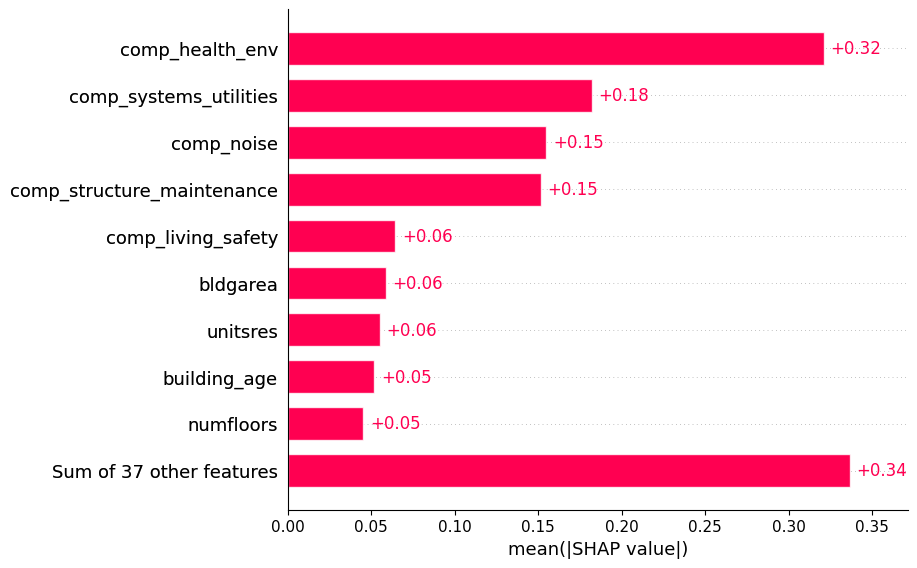

In [39]:
model = xgboost.XGBRegressor()
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.bar(shap_values)

In [40]:
top_features_idx = np.argsort(model_rfr_svi.feature_importances_)[-10:]
top_features = [feature_columns[i] for i in top_features_idx]

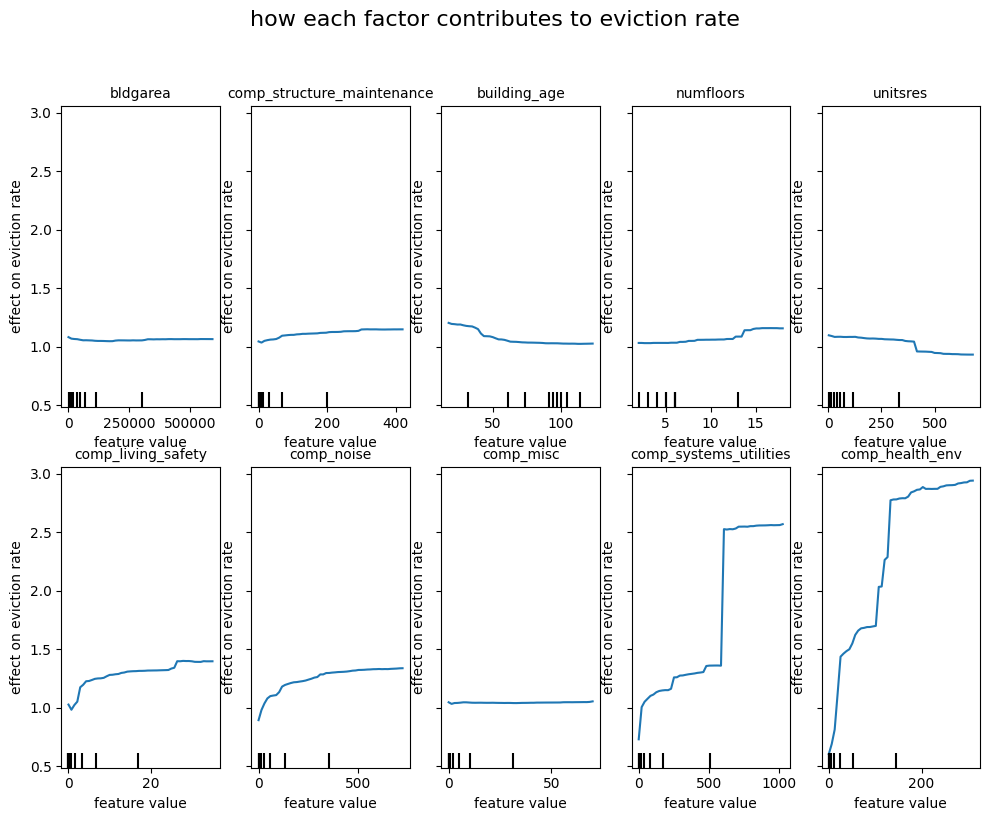

In [41]:
display = PartialDependenceDisplay.from_estimator(
    model_rfr_svi,
    X,
    features=top_features,
    kind='average',
    grid_resolution=50,
    n_cols=5,
)

plt.gcf().set_size_inches(10, 8)
plt.suptitle('how each factor contributes to eviction rate', fontsize=16, y=1.02)
for ax, feature_name in zip(display.axes_.ravel(), top_features):
    ax.set_title(feature_name, fontsize=10)
    ax.set_xlabel('feature value')
    ax.set_ylabel('effect on eviction rate')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
# see below

## **Zipcode_Level_full**

In [42]:
# idr_evi_df.shape

In [43]:
# X= idr_evi_df[all_vars]
# y= idr_evi_df['average_year_eviction_count_per_zipcode(z)']
X= zipcodes_df[feature_columns]
y= zipcodes_df['eviction_count_zipcode']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_svi.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [46]:
model_rfr_svi.score(X_test, y_test)

0.9999956828848946

PermutationExplainer explainer: 501it [02:10,  3.52it/s]


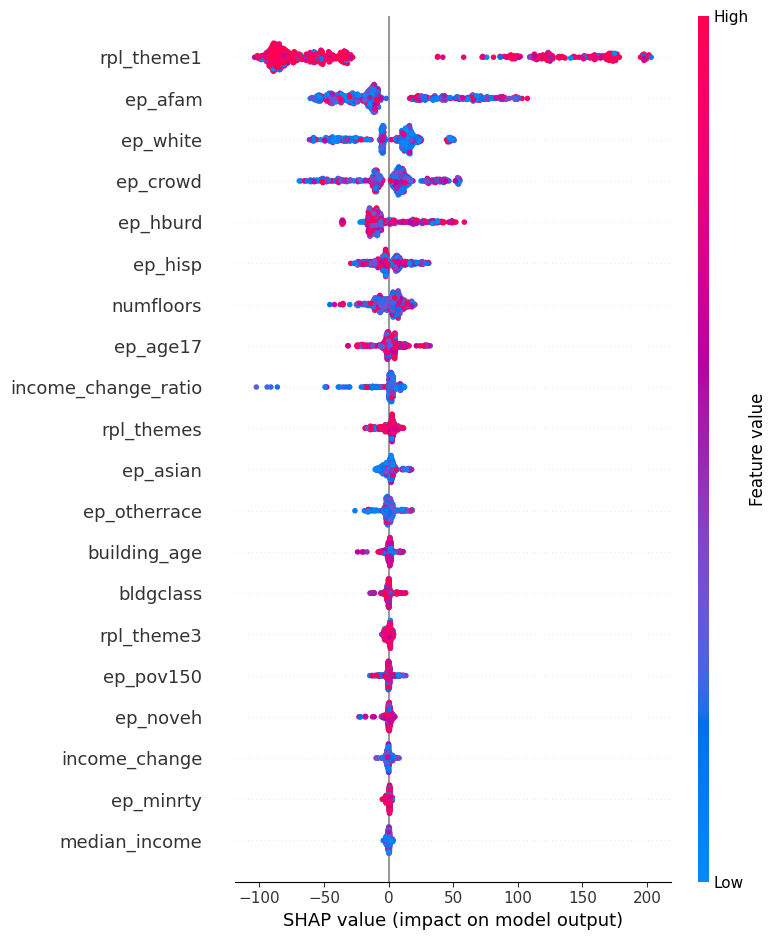

In [47]:
explainer = shap.Explainer(model_rfr_svi.predict, X)
shap_values = explainer.shap_values(X.sample(n=500))
shap.summary_plot(shap_values, X.sample(n=500))

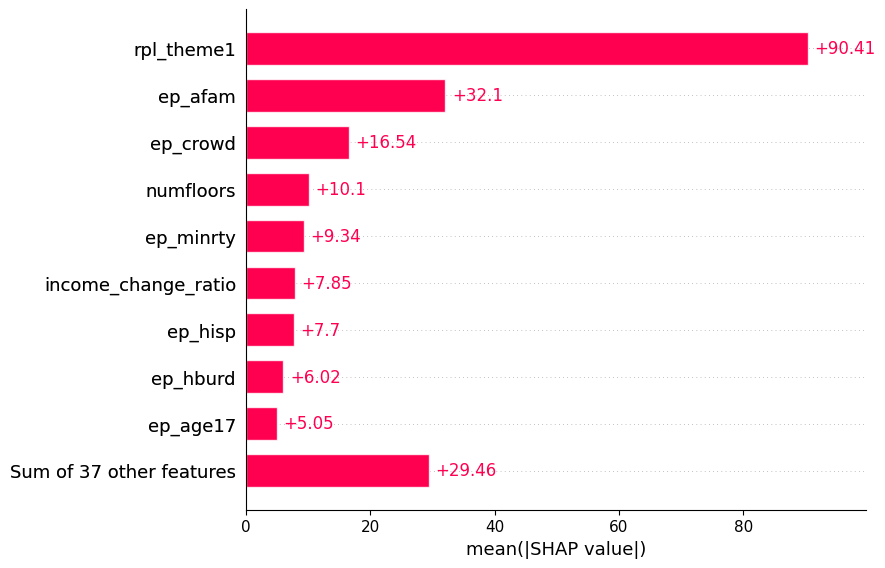

In [48]:
model = xgboost.XGBRegressor()
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.plots.bar(shap_values)

In [49]:
top_features_idx = np.argsort(model_rfr_svi.feature_importances_)[-10:]
top_features = [feature_columns[i] for i in top_features_idx]

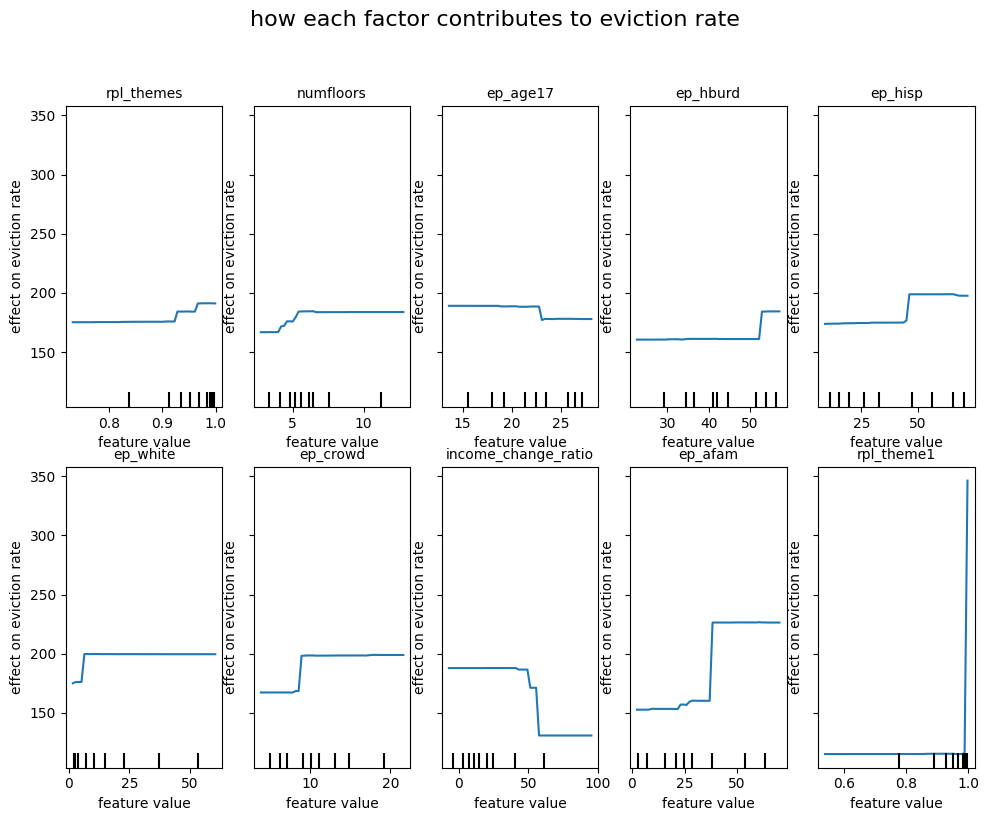

In [50]:
display = PartialDependenceDisplay.from_estimator(
    model_rfr_svi,
    X,
    features=top_features,
    kind='average',
    grid_resolution=50,
    n_cols=5,
)

plt.gcf().set_size_inches(10, 8)
plt.suptitle('how each factor contributes to eviction rate', fontsize=16, y=1.02)
for ax, feature_name in zip(display.axes_.ravel(), top_features):
    ax.set_title(feature_name, fontsize=10)
    ax.set_xlabel('feature value')
    ax.set_ylabel('effect on eviction rate')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
# see below

## **Neighborhood Level**

In [51]:
# idr_evi_df_nta = idr_evi_df.drop_duplicates(subset=['Location'])

In [52]:
# idr_evi_df.shape

In [53]:
# X= idr_evi_df[all_vars]
# y =idr_evi_df['eviction_count']
X= nta_df[feature_columns]
y= nta_df['eviction_count_nta']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_svi.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [56]:
model_rfr_svi.score(X_test, y_test)

0.999890227917773

PermutationExplainer explainer: 501it [02:07,  3.61it/s]


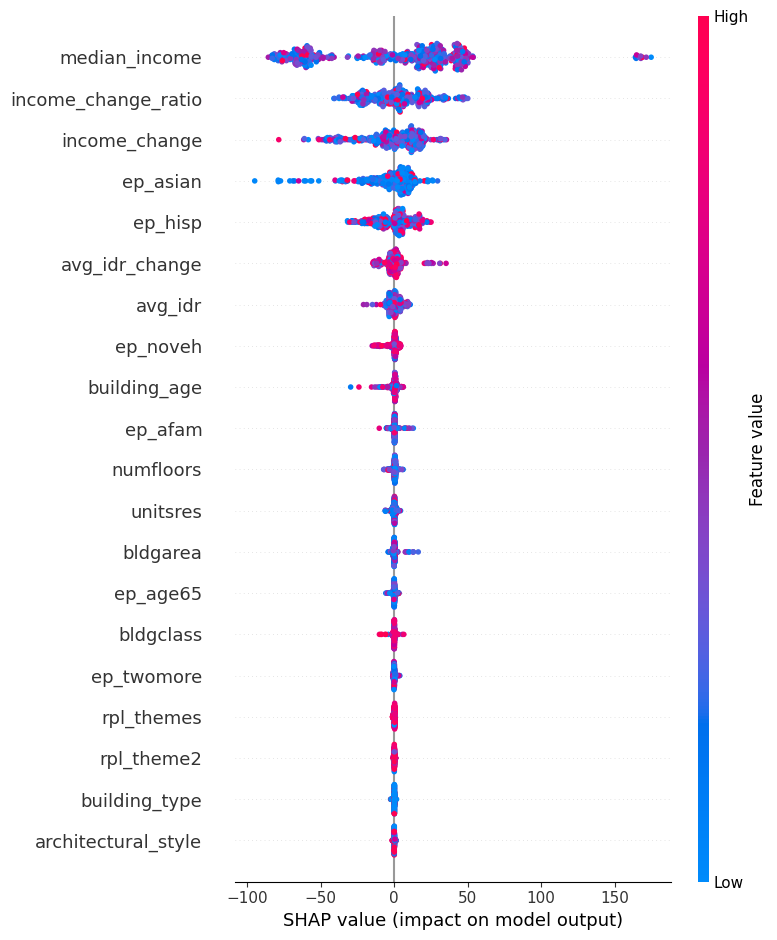

In [57]:
# model.predict instead of model, faster
explainer = shap.Explainer(model_rfr_svi.predict, X)
# need to only select the first few hundreds of samples to run
shap_values = explainer.shap_values(X.sample(n=500))
shap.summary_plot(shap_values, X.sample(n=500))

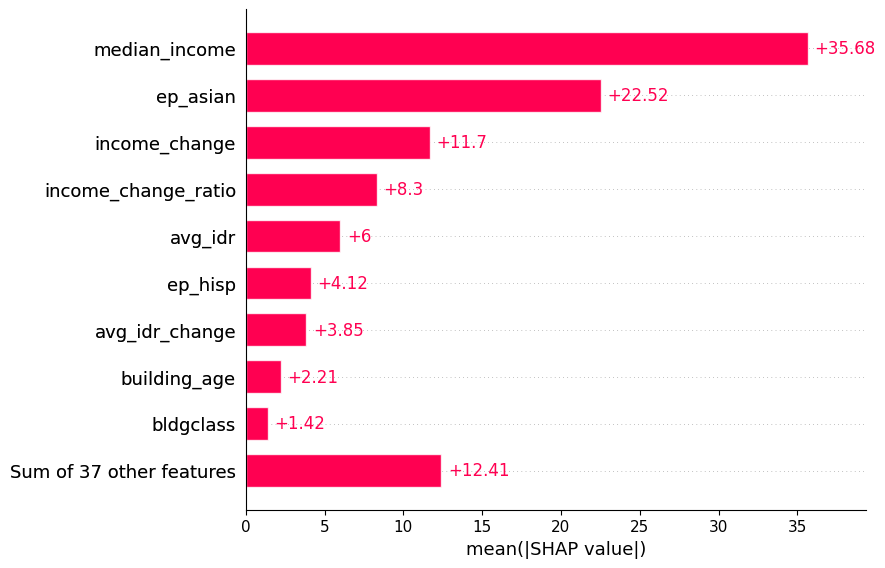

In [58]:
model = xgboost.XGBRegressor()
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.plots.bar(shap_values)

In [59]:
top_features_idx = np.argsort(model_rfr_svi.feature_importances_)[-10:]
top_features = [feature_columns[i] for i in top_features_idx]

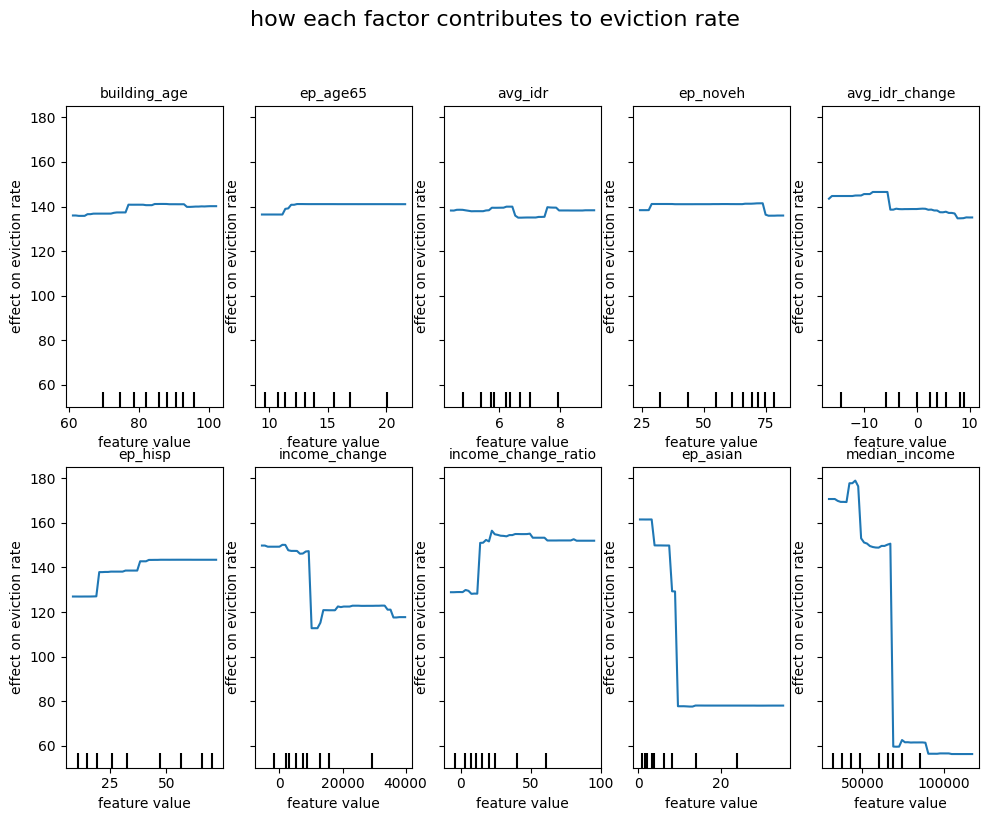

In [60]:
display = PartialDependenceDisplay.from_estimator(
    model_rfr_svi,
    X,
    features=top_features,
    kind='average',
    grid_resolution=50,
    n_cols=5,
)

plt.gcf().set_size_inches(10, 8)
plt.suptitle('how each factor contributes to eviction rate', fontsize=16, y=1.02)
for ax, feature_name in zip(display.axes_.ravel(), top_features):
    ax.set_title(feature_name, fontsize=10)
    ax.set_xlabel('feature value')
    ax.set_ylabel('effect on eviction rate')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
# see below

# **correlation test**

In [61]:
# idr_evi_df[all_vars]

In [62]:
# idr_evi_df.rename(columns= {'mediaon_income': 'median_income'})
# idr_evi_df.rename(columns = {'mediaon_income': 'median_income'})

In [63]:
# len(all_vars)

In [64]:
unit_df['median_income'] = unit_df['median_income']*(-1)
bin_df['median_income'] = bin_df['median_income']*(-1)
zipcodes_df['median_income'] = zipcodes_df['median_income']*(-1)
nta_df['median_income'] = nta_df['median_income']*(-1)

In [65]:
df_spearman = unit_df[['eviction_count_unit'] + feature_columns]
# corret way to combine columns, saving space
corr_matrix = df_spearman.corr(method='spearman')

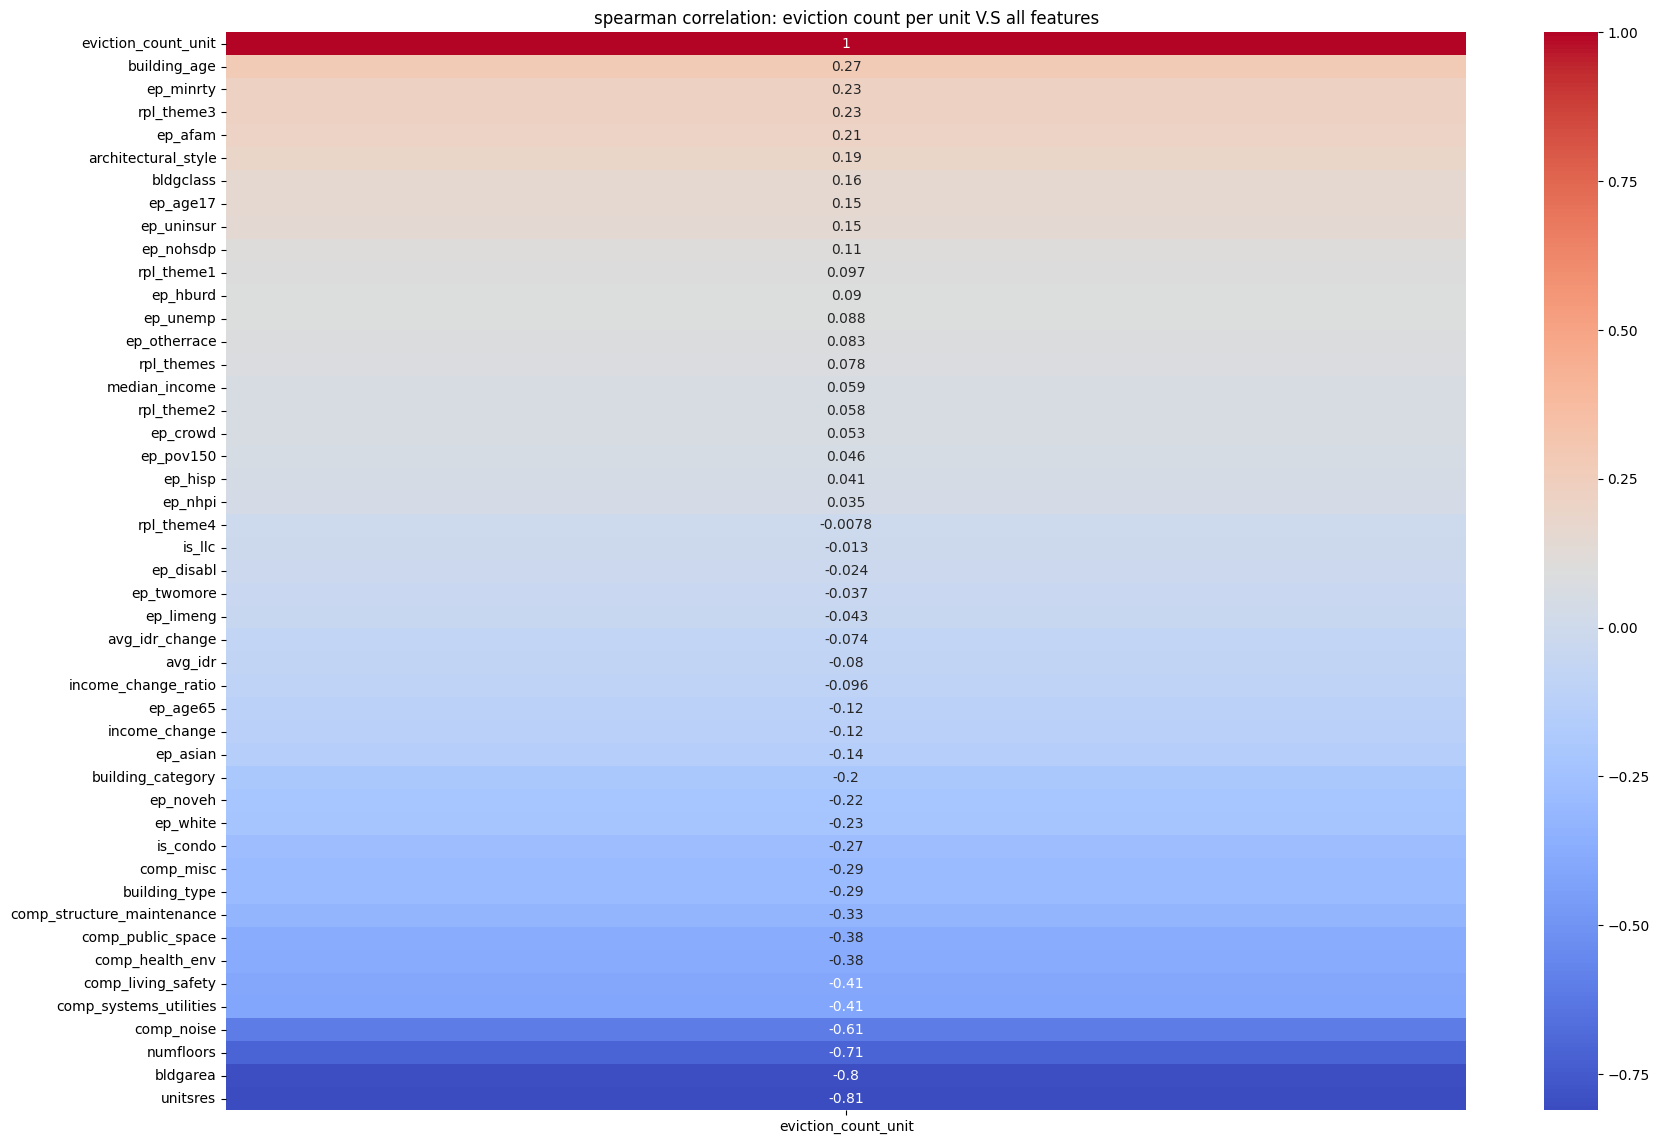

In [66]:
plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix[['eviction_count_unit']].sort_values(by='eviction_count_unit', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('spearman correlation: eviction count per unit V.S all features')
plt.show()

In [67]:
# corr_matrix[['average_year_eviction_count(building)']]

In [68]:
df_spearman = bin_df[['eviction_count_building'] + feature_columns]
# corret way to combine columns, saving space

corr_matrix = df_spearman.corr(method='spearman')

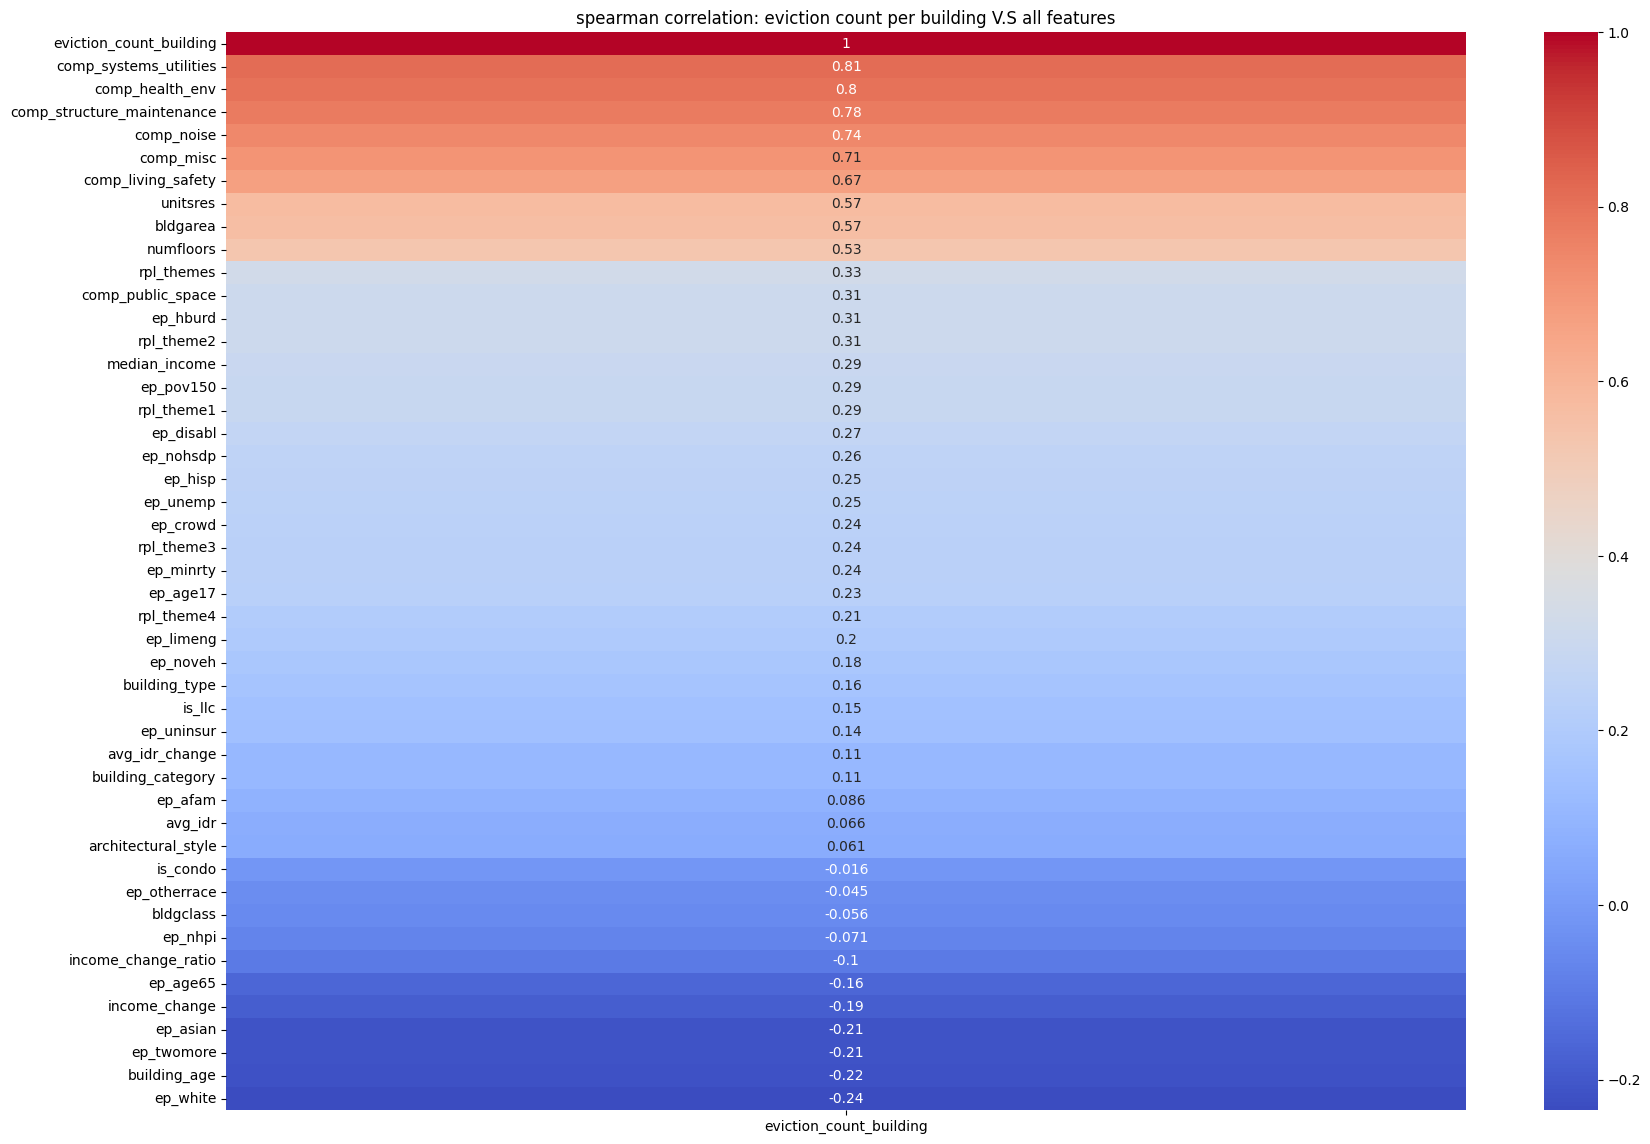

In [69]:
plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix[['eviction_count_building']].sort_values(by='eviction_count_building', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('spearman correlation: eviction count per building V.S all features')
plt.show()

In [70]:
df_spearman = zipcodes_df[['eviction_count_zipcode'] + feature_columns]
# corret way to combine columns, saving space

corr_matrix = df_spearman.corr(method='spearman')

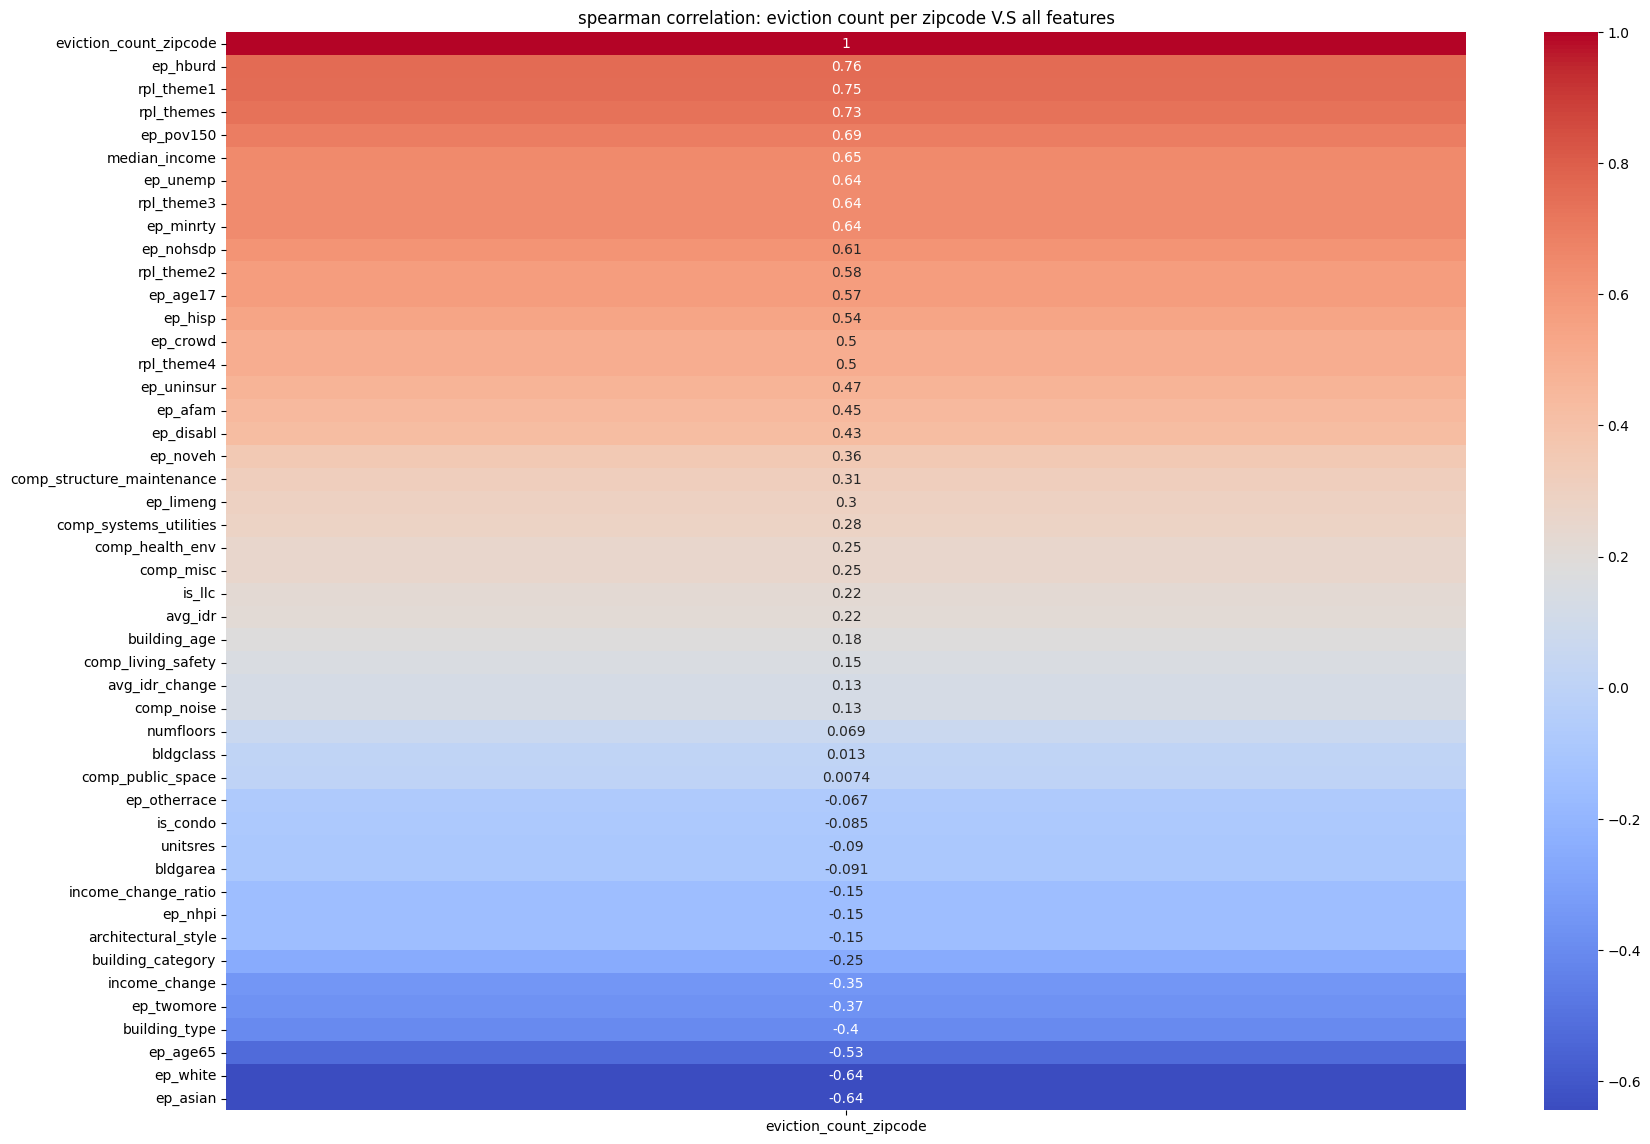

In [71]:
plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix[['eviction_count_zipcode']].sort_values(by='eviction_count_zipcode', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('spearman correlation: eviction count per zipcode V.S all features')
plt.show()

In [72]:
df_spearman = nta_df[['eviction_count_nta'] + feature_columns]
# corret way to combine columns, saving space

corr_matrix = df_spearman.corr(method='spearman')

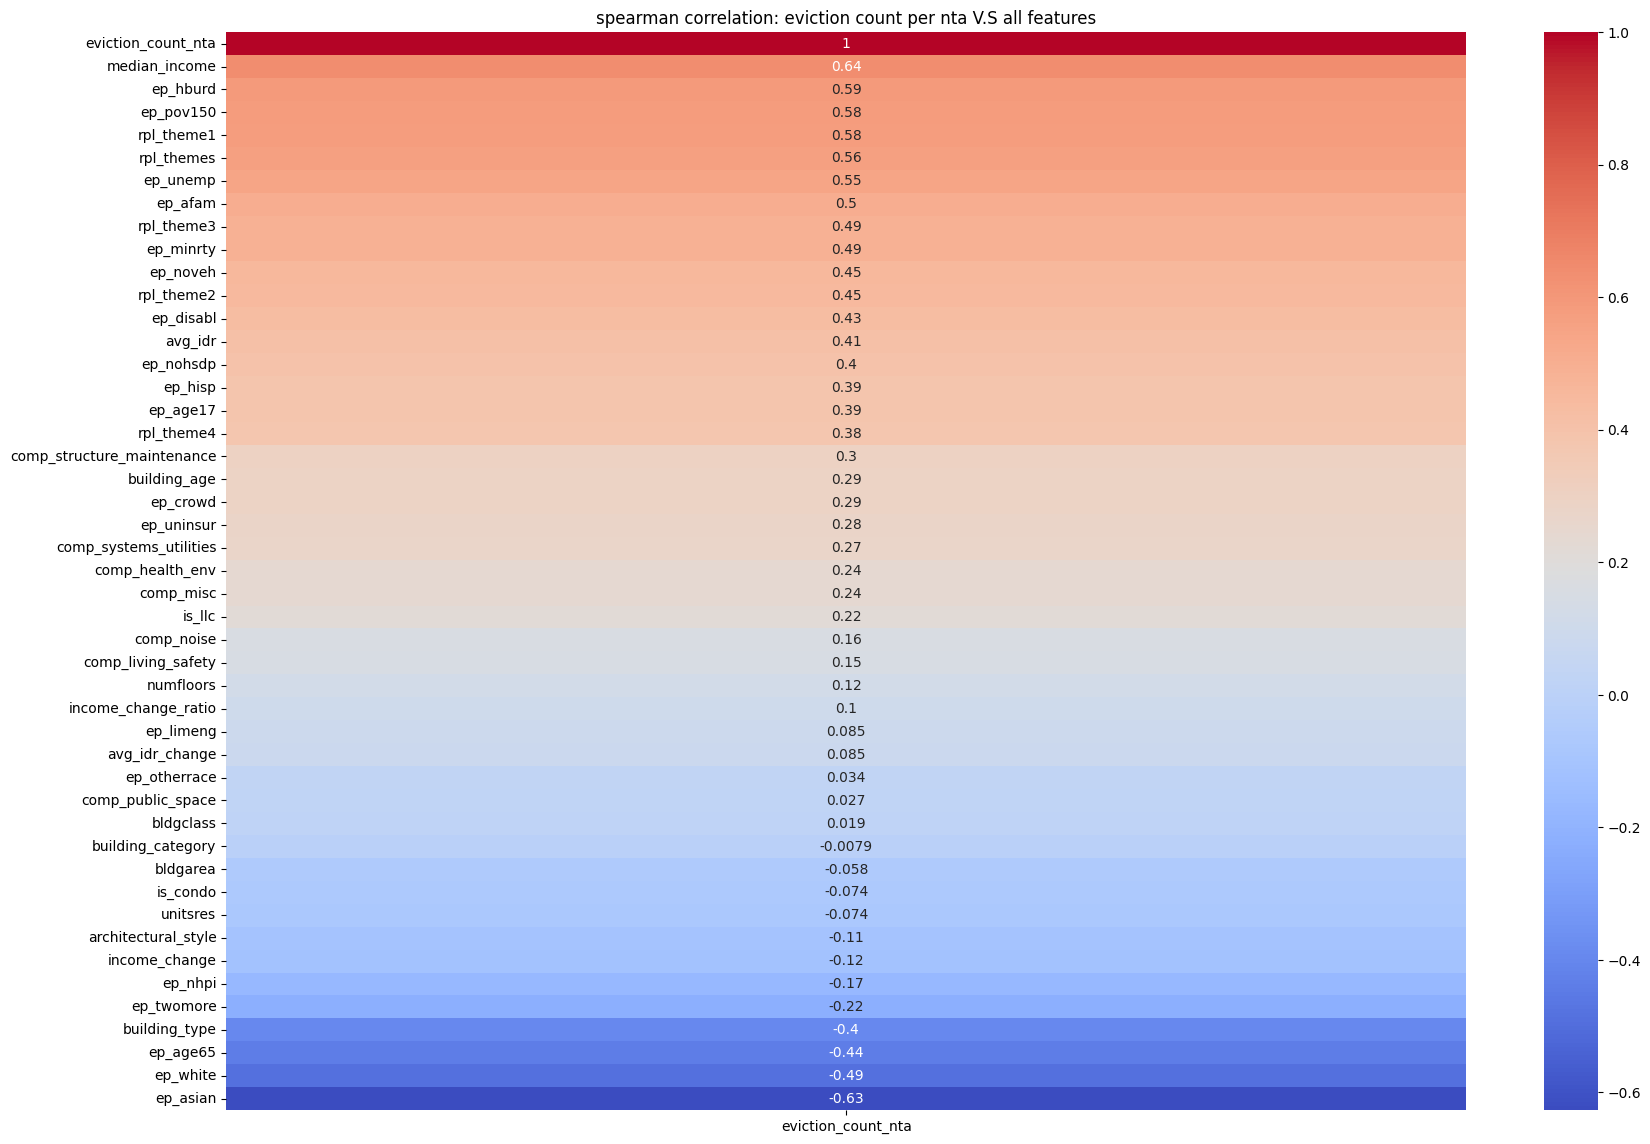

In [73]:
plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix[['eviction_count_nta']].sort_values(by='eviction_count_nta', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('spearman correlation: eviction count per nta V.S all features')
plt.show()

In [74]:
# average_year_eviction_count_per_unit(building)